In [1]:
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import utils
from astropy import stats
from photutils import CircularAnnulus, CircularAperture
from photutils.aperture import aperture_photometry as aper_phot
import numpy as np
#import matplotlib.colors as colors

In [2]:
fits_image_filename='SVS13.fits'

In [3]:
hdul = fits.open(fits_image_filename)
w=WCS(hdul[0].header)
data = hdul[0].data
hdul.close()

indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
indices in parameterized keywords must not have leading zeroes. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


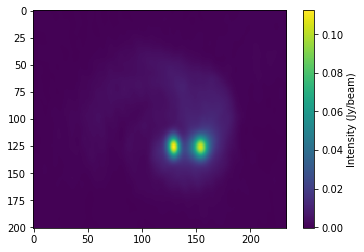

In [4]:
plt.clf()
plt.imshow(data)
cbar=plt.colorbar()
cbar.set_label('Intensity (Jy/beam)', rotation=90)
plt.show()

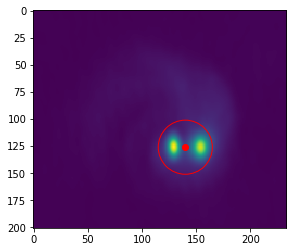

In [5]:
#I'm going to average in annulus centered in (x,y), with radius greater than r (in px). 
x_orig=140 #x coordinate of the central (red) point
y_orig=126 #y coordinate of the central (red) point
r = 25 # radius of the (red) circle in pixels 
orig_pix = (x_orig,y_orig)
plt.imshow(data)
plt.plot(x_orig,y_orig, 'ro')
circle1 = plt.Circle(orig_pix, r, color='r',fill=False)
fig = plt.gcf()
ax = fig.gca()
ax.add_artist(circle1)
plt.show()

In [6]:
width = 1 #width of the annulus in pixels
lim = min(np.array(data.shape)-[y_orig+1,x_orig+1]) #distance from the central point to the image edges)
aper = [CircularAnnulus(orig_pix, i, i+width) for i in np.arange(r,int(lim),width)]
phot = aper_phot(data,aper)
flux_aper = [phot['aperture_sum_'+str(i)][0] for i in np.arange(len(aper))]
area_aper =  [i.area for i in aper]
aver_aper = np.array(flux_aper)/np.array(area_aper)

In [10]:
#make a fits with the average values
#create new array with shape of data
zero_data=np.zeros(data.shape)
#making the central pixels the original ones  
aveg_data=zero_data.copy()
central_aperture = CircularAperture(orig_pix, r)
mask_central = central_aperture.to_mask(method='center') 
im_central=mask_central.multiply(data)
aveg_data[y_orig-r:y_orig+r+1,x_orig-r:x_orig+r+1]=im_central
data_no_central=data-aveg_data

In [12]:
#make masks from apertures
mask_aper = [i.to_mask(method='center') for i in aper] 
#create masks from the apertures filled with the averaged values 
im=[i.multiply(data) for i in mask_aper]
for i, avg in enumerate(aver_aper):
    mask = im[i] != 0
    im[i][mask] = avg

In [13]:
for mask in im:
    semi_axis=int((mask.shape[0]-1)/2)
    aveg_data[y_orig-semi_axis:y_orig+semi_axis+1,x_orig-semi_axis:x_orig+semi_axis+1]=aveg_data[y_orig-semi_axis:y_orig+semi_axis+1,x_orig-semi_axis:x_orig+semi_axis+1]+mask
new_data=data-aveg_data

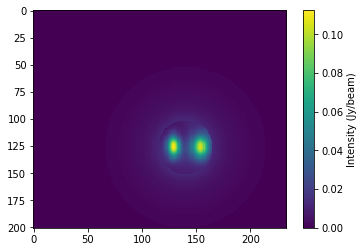

In [14]:
plt.clf()
plt.imshow(aveg_data)
cbar=plt.colorbar()
cbar.set_label('Intensity (Jy/beam)', rotation=90)
plt.show()

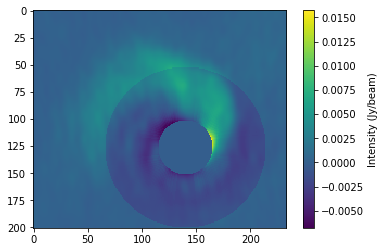

In [15]:
plt.clf()
plt.imshow(new_data)
cbar=plt.colorbar()
cbar.set_label('Intensity (Jy/beam)', rotation=90)
plt.show()

# para comparar

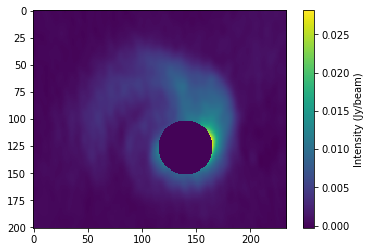

In [17]:
plt.clf()
plt.imshow(data_no_central)
cbar=plt.colorbar()
cbar.set_label('Intensity (Jy/beam)', rotation=90)
plt.show()